# ML Spam Email Classifier (Transformer Fine-Tuning)

This notebook trains a Transformer-based binary classifier to label emails as SPAM (1) or HAM (0).

Pipeline:
1. Setup
2. Config
3. Dependencies
4. Imports
5. Utilities
6. Data Loading
7. Splits
8. Tokenization
9. Training
10. Evaluation
11. Inference
12. Baseline
13. Troubleshooting


### TREC07 reminder
To include TREC07:
1. Read and accept the agreement: https://plg.uwaterloo.ca/~gvcormac/treccorpus07/
2. Download `trec07p.tgz` (the 255 MB corpus).
3. Place it at `./data/trec07p.tgz`.
4. Re-run the "Load All Datasets" cell.


## Setup
Reports environment details and validates the expected virtual environment.


In [2]:
import os
import sys
import platform
import subprocess
import shutil
from pathlib import Path


def _has_nvidia_gpu() -> bool:
    if os.environ.get("CUDA_PATH") or os.environ.get("CUDA_HOME") or os.environ.get("NVIDIA_VISIBLE_DEVICES"):
        return True
    if shutil.which("nvidia-smi"):
        try:
            res = subprocess.run(["nvidia-smi", "-L"], capture_output=True, text=True)
            return res.returncode == 0 and res.stdout.strip() != ""
        except Exception:
            return True
    return False


def _check_expected_venv(expected_dir: str, require: bool) -> None:
    expected_path = Path(expected_dir)
    if not expected_path.is_absolute():
        expected_path = Path.cwd() / expected_path
    expected_path = expected_path.resolve()

    exe_path = Path(sys.executable).resolve()
    in_expected = expected_path in exe_path.parents or exe_path.parent == expected_path

    if not in_expected:
        msg = f"Kernel python is not inside expected venv: {expected_path}\nActual: {exe_path}"
        if require:
            raise RuntimeError(msg)
        else:
            print("WARN:", msg)
    else:
        print("OK: Kernel matches expected venv:", expected_path)


cfg_local = globals().get("cfg", None)
expected_dir = getattr(cfg_local, "EXPECTED_VENV_DIR", ".venv")
require_expected = getattr(cfg_local, "REQUIRE_EXPECTED_VENV", False)

print("Python:", sys.version.replace("\n", " "))
print("Executable:", sys.executable)
print("OS:", platform.platform())
print("GPU (NVIDIA detected):", _has_nvidia_gpu())
_check_expected_venv(expected_dir, require_expected)
print("Note: If you change EXPECTED_VENV_DIR or REQUIRE_EXPECTED_VENV in the config cell, re-run this cell.")


Python: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Executable: d:\שולחן עבודה\בית ספר\LLM-Spam-project\.venv\Scripts\python.exe
OS: Windows-11-10.0.26200-SP0
GPU (NVIDIA detected): True
OK: Kernel matches expected venv: D:\שולחן עבודה\בית ספר\LLM-Spam-project\.venv
Note: If you change EXPECTED_VENV_DIR or REQUIRE_EXPECTED_VENV in the config cell, re-run this cell.


## Config
Change values in this cell only.


In [3]:
from dataclasses import dataclass
from typing import Optional, Tuple
from pathlib import Path


@dataclass
class CFG:
    # Environment / installs
    EXPECTED_VENV_DIR: str = ".venv"
    REQUIRE_EXPECTED_VENV: bool = False
    INSTALL_DEPS: bool = True
    TORCH_VARIANT: str = "auto"  # auto | cuda | cpu
    TORCH_INDEX_URL: str = "https://download.pytorch.org/whl/cu121"

    # Hugging Face cache (must be ASCII-only on Windows for SentencePiece)
    HF_CACHE_DIR: str = "./.hf_cache"
    HF_DISABLE_SYMLINKS_WARNING: bool = True

    # Reproducibility
    SEED: int = 42

    # Model
    MODEL_NAME: str = "xlm-roberta-base"

    # Output directories
    OUTPUT_DIR: str = "./globalSpm.model"
    EN_OUTPUT_DIR: str = "./spmEN.model"

    # Training hyperparameters
    MAX_LEN: int = 256
    TRAIN_EPOCHS: int = 2
    TRAIN_BATCH: int = 4
    EVAL_BATCH: int = 8
    GRAD_ACCUM: int = 2

    LR: float = 2e-5
    WEIGHT_DECAY: float = 0.01

    # Dataset controls
    MAX_PER_SOURCE: Optional[int] = 40000
    TREC07_TGZ_PATH: str = "./data/trec07p.tgz"

    ENABLE_ENRON: bool = True
    ENABLE_SPAMASSASSIN: bool = True
    ENABLE_CSDMC2010: bool = True
    ENABLE_TREC07: bool = True

    # Quick dev mode
    QUICK_DEV: bool = False
    QUICK_DEV_MAX_PER_SOURCE: int = 2000
    QUICK_DEV_SKIP_SOURCES: Tuple[str, ...] = ()

    # Training perf
    USE_GRAD_CHECKPOINTING: bool = True
    NUM_WORKERS: int = 0

    # Optional extras
    RUN_SPAMBASE_BASELINE: bool = True
    RUN_CONFUSION_MATRIX: bool = True


cfg = CFG()

Path(cfg.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path("data").mkdir(parents=True, exist_ok=True)

print("CFG loaded:", cfg)



CFG loaded: CFG(EXPECTED_VENV_DIR='.venv', REQUIRE_EXPECTED_VENV=False, INSTALL_DEPS=True, TORCH_VARIANT='auto', TORCH_INDEX_URL='https://download.pytorch.org/whl/cu121', HF_CACHE_DIR='./.hf_cache', HF_DISABLE_SYMLINKS_WARNING=True, SEED=42, MODEL_NAME='xlm-roberta-base', OUTPUT_DIR='./globalSpm.model', EN_OUTPUT_DIR='./spmEN.model', MAX_LEN=256, TRAIN_EPOCHS=2, TRAIN_BATCH=4, EVAL_BATCH=8, GRAD_ACCUM=2, LR=2e-05, WEIGHT_DECAY=0.01, MAX_PER_SOURCE=40000, TREC07_TGZ_PATH='./data/trec07p.tgz', ENABLE_ENRON=True, ENABLE_SPAMASSASSIN=True, ENABLE_CSDMC2010=True, ENABLE_TREC07=True, QUICK_DEV=False, QUICK_DEV_MAX_PER_SOURCE=2000, QUICK_DEV_SKIP_SOURCES=(), USE_GRAD_CHECKPOINTING=True, NUM_WORKERS=0, RUN_SPAMBASE_BASELINE=True, RUN_CONFUSION_MATRIX=True)


## Dependencies
Idempotent dependency manager. Installs only missing or out-of-spec packages.


In [3]:
import os
import sys
import subprocess
import shutil
from importlib import metadata


def _pip_install(*args):
    cmd = [sys.executable, "-m", "pip", "install", "--upgrade", "--prefer-binary", *args]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)


def _pip_uninstall(pkg):
    cmd = [sys.executable, "-m", "pip", "uninstall", "-y", pkg]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)


def _ensure_packaging():
    try:
        import packaging  # noqa: F401
        return True
    except Exception:
        if cfg.INSTALL_DEPS:
            _pip_install("packaging>=23.2")
            return True
        else:
            print("INSTALL_DEPS=False; packaging not installed.")
            return False


_packaging_ready = _ensure_packaging()

if _packaging_ready:
    from packaging.version import Version
    from packaging.specifiers import SpecifierSet
else:
    Version = None
    SpecifierSet = None


def _version_of(pkg):
    try:
        return metadata.version(pkg)
    except metadata.PackageNotFoundError:
        return None


def _needs_install(current, spec):
    if current is None:
        return True
    if not spec:
        return False
    if not _packaging_ready:
        return False
    return Version(current) not in SpecifierSet(spec)


def ensure_packages(specs):
    to_install = []
    for pkg, spec in specs.items():
        cur = _version_of(pkg)
        if _needs_install(cur, spec):
            to_install.append(f"{pkg}{spec}")
    if not to_install:
        return False
    if cfg.INSTALL_DEPS:
        _pip_install(*to_install)
    else:
        print("INSTALL_DEPS=False; skipping install for:", to_install)
    return True


def uninstall_google_placeholder():
    if _version_of("google") is not None:
        if cfg.INSTALL_DEPS:
            _pip_uninstall("google")
            return True
        else:
            print("INSTALL_DEPS=False; skipping uninstall of 'google'.")
    return False


def _nvidia_available():
    if os.environ.get("CUDA_PATH") or os.environ.get("CUDA_HOME") or os.environ.get("NVIDIA_VISIBLE_DEVICES"):
        return True
    if shutil.which("nvidia-smi"):
        try:
            res = subprocess.run(["nvidia-smi", "-L"], capture_output=True, text=True)
            return res.returncode == 0 and res.stdout.strip() != ""
        except Exception:
            return True
    return False


def detect_torch_variant(cfg):
    v = cfg.TORCH_VARIANT.lower()
    if v in ("cuda", "cpu"):
        return v
    return "cuda" if _nvidia_available() else "cpu"


def ensure_torch(variant):
    desired = variant
    has_torch = False
    torch_has_cuda = False
    try:
        import torch  # noqa: F401
        import torch as _torch
        has_torch = True
        torch_has_cuda = _torch.version.cuda is not None
    except Exception:
        has_torch = False

    need_install = False
    if not has_torch:
        need_install = True
    elif desired == "cuda" and not torch_has_cuda:
        need_install = True

    if need_install:
        if cfg.INSTALL_DEPS:
            args = ["torch", "torchvision", "torchaudio"]
            if desired == "cuda":
                _pip_install("--index-url", cfg.TORCH_INDEX_URL, *args)
            else:
                _pip_install(*args)
        else:
            print("INSTALL_DEPS=False; skipping torch install.")
    else:
        if desired == "cpu" and torch_has_cuda:
            print("Note: CUDA torch is installed but TORCH_VARIANT=cpu. Keeping existing install.")

    import torch
    print("Torch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())


changed = False
changed |= uninstall_google_placeholder()

BASE_SPECS = {
    "numpy": "==1.26.4",
    "scipy": "==1.11.4",
    "pandas": "==2.2.2",
    "scikit-learn": "==1.5.2",
    "pyarrow": "==15.0.2",
    "xxhash": "==3.5.0",
    "tokenizers": "==0.19.1",
    "safetensors": "==0.4.5",
    "protobuf": "==4.25.3",
    "sentencepiece": "==0.2.0",
    "tqdm": "==4.66.5",
    "huggingface-hub": "==0.24.5",
    "datasets": "==2.20.0",
    "transformers": "==4.44.2",
    "accelerate": "==0.33.0",
    "fsspec": "==2024.6.1",
    "packaging": ">=23.2",
}

changed |= ensure_packages(BASE_SPECS)

variant = detect_torch_variant(cfg)
print("Torch variant:", variant)
ensure_torch(variant)

if changed:
    print("Note: If installs occurred, restart the kernel before continuing.")



Torch variant: cuda
Torch: 2.5.1+cu121
CUDA available: True


## Imports


In [6]:
import os
import re
import io
import tarfile
import zipfile
import hashlib
import random
from pathlib import Path
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)
from transformers.utils import logging as hf_logging

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import torch

from email import policy
from email.parser import BytesParser

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
hf_logging.set_verbosity_error()


## Utilities


In [8]:
from urllib.request import urlopen, Request


def log_info(*args):
    print(*args)


def seed_everything(seed: int) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    set_seed(seed)


def _normalize_text(text: str) -> str:
    text = text.replace("\r\n", "\n")
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r"[ \t]{2,}", " ", text)
    return text.strip()


def _strip_html(raw: str) -> str:
    raw = re.sub(r"(?is)<(script|style).*?>.*?</\\1>", " ", raw)
    raw = re.sub(r"(?s)<[^>]+>", " ", raw)
    raw = re.sub(r"&nbsp;|&amp;|&lt;|&gt;|&quot;|&#39;", " ", raw)
    return _normalize_text(raw)


def parse_eml_bytes(raw_bytes: bytes) -> str:
    msg = BytesParser(policy=policy.default).parsebytes(raw_bytes)

    subject = msg.get("subject", "") or ""
    from_ = msg.get("from", "") or ""
    to_ = msg.get("to", "") or ""

    body_parts = []
    if msg.is_multipart():
        for part in msg.walk():
            disp = str(part.get("Content-Disposition", "")).lower()
            if "attachment" in disp:
                continue
            if part.get_content_type() in ("text/plain", "text/html"):
                try:
                    body_parts.append(part.get_content())
                except Exception:
                    pass
    else:
        try:
            body_parts.append(msg.get_content())
        except Exception:
            body_parts.append("")

    body = "\n".join([p for p in body_parts if p])
    body = _strip_html(body)

    text = f"From: {from_}\nTo: {to_}\nSubject: {subject}\n\n{body}"
    return _normalize_text(text)


def _hash_text(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8", errors="ignore")).hexdigest()


def dedup_text_dataset(ds: Dataset) -> Dataset:
    hashes = ds.map(lambda ex: {"_h": _hash_text(ex["text"])})
    df = hashes.to_pandas()
    keep = ~df["_h"].duplicated()
    kept_idx = np.where(keep.values)[0].tolist()
    return ds.select(kept_idx)


def _is_within_directory(base: Path, target: Path) -> bool:
    base = Path(base).resolve()
    target = Path(target).resolve()
    try:
        target.relative_to(base)
        return True
    except ValueError:
        return False


def safe_extract_tar(tar: tarfile.TarFile, path: Path) -> None:
    path = Path(path)
    for member in tar.getmembers():
        member_path = path / member.name
        if not _is_within_directory(path, member_path):
            raise RuntimeError(f"Blocked path traversal in tar: {member.name}")
    tar.extractall(path=path)


def safe_extract_zip(zf: zipfile.ZipFile, path: Path) -> None:
    path = Path(path)
    for member in zf.namelist():
        member_path = path / member
        if not _is_within_directory(path, member_path):
            raise RuntimeError(f"Blocked path traversal in zip: {member}")
    zf.extractall(path=path)


def download_file(url: str, dest_path: str, chunk_size: int = 1 << 20) -> None:
    dest = Path(dest_path)
    if dest.exists():
        return
    dest.parent.mkdir(parents=True, exist_ok=True)

    req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    try:
        with urlopen(req) as r, open(dest, "wb") as f:
            total = r.headers.get("Content-Length")
            total = int(total) if total is not None else None
            pbar = tqdm(total=total, unit="B", unit_scale=True, desc=f"Downloading {dest.name}")
            while True:
                data = r.read(chunk_size)
                if not data:
                    break
                f.write(data)
                pbar.update(len(data))
            pbar.close()
    except Exception as e:
        raise RuntimeError(f"Failed to download {url}: {e}")


def cap_dataset(ds: Dataset, n: Optional[int]) -> Dataset:
    if n is None:
        return ds
    return ds.select(range(min(n, len(ds))))


seed_everything(cfg.SEED)
Path(cfg.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)



## Dataset Loaders


In [9]:
from datasets import Dataset


def load_enronspam_hf() -> Dataset:
    ds = load_dataset("AlignmentResearch/EnronSpam", split="train")

    def _map(ex):
        content = ex.get("content", "")
        if isinstance(content, list):
            content = "\n".join([c for c in content if c])
        return {"text": _normalize_text(str(content)), "label": int(ex["clf_label"]), "source": "enron"}

    return ds.map(_map, remove_columns=ds.column_names)


def load_spamassassin_public_corpus(workdir: str = "./data/spamassassin_corpus") -> Dataset:
    urls = {
        "easy_ham": "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2",
        "easy_ham_2": "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2",
        "hard_ham": "https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2",
        "spam": "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2",
        "spam_2": "https://spamassassin.apache.org/old/publiccorpus/20030228_spam_2.tar.bz2",
    }

    workdir = Path(workdir)
    workdir.mkdir(parents=True, exist_ok=True)

    def _dl_and_extract(name: str, url: str) -> Path:
        tar_path = workdir / Path(url).name
        out_dir = workdir / name
        if not out_dir.exists():
            out_dir.mkdir(parents=True, exist_ok=True)
            if not tar_path.exists():
                download_file(url, str(tar_path))
            with tarfile.open(tar_path, "r:bz2") as tf:
                safe_extract_tar(tf, out_dir)
        return out_dir

    roots = {k: _dl_and_extract(k, v) for k, v in urls.items()}

    def _iter_files(root: Path):
        for dirpath, _, filenames in os.walk(root):
            for fn in filenames:
                fp = Path(dirpath) / fn
                if fp.is_file():
                    yield fp

    rows = []

    ham_roots = [roots["easy_ham"], roots["easy_ham_2"], roots["hard_ham"]]
    spam_roots = [roots["spam"], roots["spam_2"]]

    for r in ham_roots:
        files = list(_iter_files(r))
        for fp in tqdm(files, desc=f"Parsing {r.name}"):
            try:
                text = parse_eml_bytes(fp.read_bytes())
                if text:
                    rows.append({"text": text, "label": 0, "source": "spamassassin"})
            except Exception:
                continue

    for r in spam_roots:
        files = list(_iter_files(r))
        for fp in tqdm(files, desc=f"Parsing {r.name}"):
            try:
                text = parse_eml_bytes(fp.read_bytes())
                if text:
                    rows.append({"text": text, "label": 1, "source": "spamassassin"})
            except Exception:
                continue

    return Dataset.from_list(rows)


def load_csdmc2010_github(workdir: str = "./data/csdmc2010") -> Dataset:
    ham_url = "https://github.com/zrz1996/Spam-Email-Classifier-DataSet/raw/master/ham.zip"
    spam_url = "https://github.com/zrz1996/Spam-Email-Classifier-DataSet/raw/master/spam.zip"

    workdir = Path(workdir)
    workdir.mkdir(parents=True, exist_ok=True)

    ham_zip = workdir / "ham.zip"
    spam_zip = workdir / "spam.zip"

    download_file(ham_url, str(ham_zip))
    download_file(spam_url, str(spam_zip))

    ham_dir = workdir / "ham"
    spam_dir = workdir / "spam"

    if not ham_dir.exists():
        with zipfile.ZipFile(ham_zip, "r") as z:
            safe_extract_zip(z, ham_dir)
    if not spam_dir.exists():
        with zipfile.ZipFile(spam_zip, "r") as z:
            safe_extract_zip(z, spam_dir)

    def _read_dir(root: Path, label: int) -> List[Dict]:
        rows = []
        files = [p for p in root.rglob("*") if p.is_file()]
        for fp in tqdm(files, desc=f"Parsing {root.name}"):
            try:
                text = parse_eml_bytes(fp.read_bytes())
                if text:
                    rows.append({"text": text, "label": label, "source": "csdmc2010"})
            except Exception:
                continue
        return rows

    rows = _read_dir(ham_dir, 0) + _read_dir(spam_dir, 1)
    return Dataset.from_list(rows)


def load_trec07_from_tgz(tgz_path: str, extract_to: str = "./data/trec07p") -> Dataset:
    tgz_path = Path(tgz_path)
    if not tgz_path.exists():
        raise FileNotFoundError(f"trec07p.tgz not found at: {tgz_path}")

    extract_to = Path(extract_to)
    if not extract_to.exists():
        extract_to.mkdir(parents=True, exist_ok=True)
        with tarfile.open(tgz_path, "r:gz") as tar:
            safe_extract_tar(tar, extract_to)

    base = extract_to / "trec07p"
    index_path = base / "full" / "index"

    if not index_path.exists():
        raise FileNotFoundError("Expected trec07p/full/index not found after extraction.")

    rows = []
    with index_path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    if cfg.MAX_PER_SOURCE is not None:
        lines = lines[: cfg.MAX_PER_SOURCE]

    for ln in tqdm(lines, desc="Parsing trec07p"):
        parts = ln.split()
        if len(parts) != 2:
            continue
        lbl, relpath = parts
        y = 1 if lbl.lower() == "spam" else 0
        fpath = base / relpath
        try:
            text = parse_eml_bytes(fpath.read_bytes())
            if text:
                rows.append({"text": text, "label": y, "source": "trec07p"})
        except Exception:
            continue

    return Dataset.from_list(rows)


def load_spambase_hf() -> Tuple[np.ndarray, np.ndarray]:
    ds = load_dataset("mstz/spambase", split="train")
    cols = ds.column_names
    label_candidates = ["label", "class", "is_spam", "spam", "target", "y"]
    label_col = None
    for c in label_candidates:
        if c in cols:
            label_col = c
            break
    if label_col is None:
        raise ValueError(f"Unexpected columns for mstz/spambase: {cols}")
    feature_cols = [c for c in cols if c != label_col]
    df = ds.to_pandas()
    X = df[feature_cols].astype(float).to_numpy()
    y = df[label_col].astype(int).to_numpy()
    return X, y


## Load All Datasets


In [22]:
from typing import Callable


def build_text_dataset(cfg) -> Dataset:
    sources = []

    cap = cfg.QUICK_DEV_MAX_PER_SOURCE if cfg.QUICK_DEV else cfg.MAX_PER_SOURCE
    skip = {s.lower() for s in cfg.QUICK_DEV_SKIP_SOURCES}

    if cfg.QUICK_DEV:
        print("Mode: QUICK_DEV")
        print("Cap per source:", cap)
        if skip:
            print("Skipping sources:", sorted(skip))

    def _maybe_add(name: str, loader: Callable[[], Dataset]) -> None:
        if cfg.QUICK_DEV and name.lower() in skip:
            print(f"Skipping {name} due to QUICK_DEV_SKIP_SOURCES")
            return
        ds = loader()
        ds = cap_dataset(ds, cap)
        sources.append(ds)

    if cfg.ENABLE_ENRON:
        _maybe_add("enron", load_enronspam_hf)
    if cfg.ENABLE_SPAMASSASSIN:
        _maybe_add("spamassassin", load_spamassassin_public_corpus)
    if cfg.ENABLE_CSDMC2010:
        _maybe_add("csdmc2010", load_csdmc2010_github)
    if cfg.ENABLE_TREC07:
        trec_path = Path(cfg.TREC07_TGZ_PATH)
        if trec_path.exists():
            _maybe_add("trec07p", lambda: load_trec07_from_tgz(str(trec_path)))
        else:
            print("TREC07 not loaded. File not found:", trec_path)
            print("To include it: place trec07p.tgz at that path and re-run this cell.")

    if not sources:
        raise RuntimeError("No datasets loaded. Enable at least one source.")

    for ds in sources:
        print(ds[0]["source"], "rows:", len(ds))

    ds_all = concatenate_datasets(sources)
    ds_all = dedup_text_dataset(ds_all)

    print("Total text rows after dedup:", len(ds_all))
    return ds_all


ds_all_text = build_text_dataset(cfg)


Parsing easy_ham:   0%|          | 0/2501 [00:00<?, ?it/s]

Parsing easy_ham_2:   0%|          | 0/1401 [00:00<?, ?it/s]

Parsing hard_ham:   0%|          | 0/251 [00:00<?, ?it/s]

Parsing spam:   0%|          | 0/501 [00:00<?, ?it/s]

Parsing spam_2:   0%|          | 0/1398 [00:00<?, ?it/s]

Parsing ham:   0%|          | 0/2951 [00:00<?, ?it/s]

Parsing spam:   0%|          | 0/1380 [00:00<?, ?it/s]

TREC07 not loaded. File not found: data\trec07p.tgz
To include it: place trec07p.tgz at that path and re-run this cell.
enron rows: 29290
spamassassin rows: 6052
csdmc2010 rows: 4331
Total text rows after dedup: 36737


## Split (Train / Val / Test)
Non-TREC sources use stratified random splits. TREC07 uses chronological order.


In [23]:
def split_random_stratified(ds: Dataset, test_size: float = 0.2, val_size: float = 0.1) -> Tuple[Dataset, Dataset, Dataset]:
    try:
        tmp = ds.train_test_split(test_size=test_size, seed=cfg.SEED, stratify_by_column="label")
    except Exception:
        tmp = ds.train_test_split(test_size=test_size, seed=cfg.SEED)

    train_ds = tmp["train"]
    test_ds = tmp["test"]

    val_frac_of_train = val_size / (1.0 - test_size)
    try:
        tmp2 = train_ds.train_test_split(test_size=val_frac_of_train, seed=cfg.SEED, stratify_by_column="label")
    except Exception:
        tmp2 = train_ds.train_test_split(test_size=val_frac_of_train, seed=cfg.SEED)

    return tmp2["train"], tmp2["test"], test_ds


def split_chronological(ds: Dataset, train_frac: float = 0.8, val_frac: float = 0.1) -> Tuple[Dataset, Dataset, Dataset]:
    n = len(ds)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)

    train_ds = ds.select(range(0, n_train))
    val_ds = ds.select(range(n_train, n_train + n_val))
    test_ds = ds.select(range(n_train + n_val, n))
    return train_ds, val_ds, test_ds


def make_splits(ds_all: Dataset) -> Tuple[Dataset, Dataset, Dataset]:
    splits = {"train": [], "val": [], "test": []}

    for src in sorted(set(ds_all["source"])):
        ds_src = ds_all.filter(lambda ex: ex["source"] == src)

        if src == "trec07p":
            tr, va, te = split_chronological(ds_src)
        else:
            tr, va, te = split_random_stratified(ds_src)

        splits["train"].append(tr)
        splits["val"].append(va)
        splits["test"].append(te)

    ds_train = concatenate_datasets(splits["train"]).shuffle(seed=cfg.SEED)
    ds_val = concatenate_datasets(splits["val"]).shuffle(seed=cfg.SEED)
    ds_test = concatenate_datasets(splits["test"]).shuffle(seed=cfg.SEED)

    return ds_train, ds_val, ds_test


ds_train, ds_val, ds_test = make_splits(ds_all_text)

print("train:", len(ds_train), "val:", len(ds_val), "test:", len(ds_test))
print("label distribution (train):", np.bincount(np.array(ds_train["label"], dtype=int)))


train: 25713 val: 3675 test: 7349
label distribution (train): [14596 11117]


## Dataset Graphs
Basic distribution plots for the train/val/test splits.


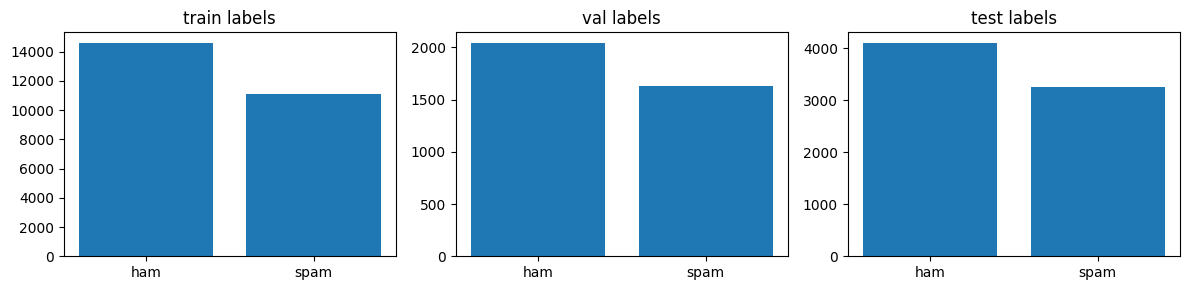

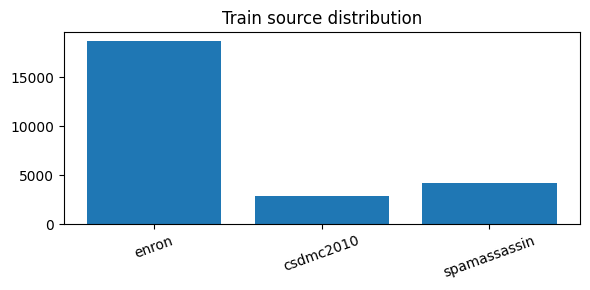

In [24]:
try:
    import matplotlib.pyplot as plt

    # Label distribution
    labels_train = np.array(ds_train["label"], dtype=int)
    labels_val = np.array(ds_val["label"], dtype=int)
    labels_test = np.array(ds_test["label"], dtype=int)

    def _count(y):
        return [int((y == 0).sum()), int((y == 1).sum())]

    counts = {
        "train": _count(labels_train),
        "val": _count(labels_val),
        "test": _count(labels_test),
    }

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    for ax, (name, vals) in zip(axes, counts.items()):
        ax.bar(["ham", "spam"], vals)
        ax.set_title(f"{name} labels")
    plt.tight_layout()
    plt.show()

    # Source distribution (train only)
    src_counts = {}
    for s in ds_train["source"]:
        src_counts[s] = src_counts.get(s, 0) + 1

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar(list(src_counts.keys()), list(src_counts.values()))
    ax.set_title("Train source distribution")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting failed. Install matplotlib to enable graphs.")
    print("Error:", e)


## Tokenize


In [26]:
from pathlib import Path
import os
import shutil
from huggingface_hub import snapshot_download


def _is_ascii_path(p: Path) -> bool:
    try:
        str(p).encode("ascii")
        return True
    except UnicodeEncodeError:
        return False


def _ascii_fallback_cache() -> Path:
    if os.name == "nt":
        drive = Path.cwd().drive or "C:"
        return Path(f"{drive}\\hf_cache")
    return Path("/tmp/hf_cache")


def _setup_hf_cache(cfg) -> Path:
    cache_dir = Path(cfg.HF_CACHE_DIR)
    if not cache_dir.is_absolute():
        cache_dir = (Path.cwd() / cache_dir).resolve()

    if not _is_ascii_path(cache_dir) or len(str(cache_dir)) > 240:
        fallback = _ascii_fallback_cache()
        print("WARN: Non-ASCII or long cache path detected. Using:", fallback)
        cache_dir = fallback

    cache_dir.mkdir(parents=True, exist_ok=True)

    os.environ["HF_HOME"] = str(cache_dir)
    os.environ["TRANSFORMERS_CACHE"] = str(cache_dir)
    if getattr(cfg, "HF_DISABLE_SYMLINKS_WARNING", True):
        os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

    print("HF cache dir:", cache_dir)
    return cache_dir


def _clear_model_cache(cache_dir: Path, model_name: str) -> None:
    hub_dir = cache_dir / "hub"
    if not hub_dir.exists():
        return

    pattern = f"models--{model_name.replace('/', '--')}"
    for p in hub_dir.glob(pattern + "*"):
        shutil.rmtree(p, ignore_errors=True)


def _download_tokenizer_snapshot(model_name: str, cache_dir: Path) -> Path:
    allow = [
        "tokenizer_config.json",
        "tokenizer.json",
        "special_tokens_map.json",
        "spm.model",
        "vocab.json",
        "merges.txt",
        "added_tokens.json",
        "config.json",
    ]
    snapshot_path = snapshot_download(
        repo_id=model_name,
        cache_dir=cache_dir,
        allow_patterns=allow,
        local_dir_use_symlinks=False,
        force_download=True,
    )
    return Path(snapshot_path)


def _print_spm_debug(snapshot_path: Path) -> None:
    spm_path = snapshot_path / "spm.model"
    if spm_path.exists():
        print("spm.model path:", spm_path)
        print("spm.model size:", spm_path.stat().st_size)
    else:
        print("spm.model not found in snapshot:", snapshot_path)


def load_tokenizer_safe(model_name: str):
    cache_dir = _setup_hf_cache(cfg)
    try:
        snapshot_path = _download_tokenizer_snapshot(model_name, cache_dir)
        # Prefer fast tokenizer (avoids sentencepiece dependency issues)
        return AutoTokenizer.from_pretrained(snapshot_path, use_fast=True)
    except Exception as e_fast:
        print("Fast tokenizer load failed; retrying slow tokenizer.")
        print("Error:", e_fast)
        _print_spm_debug(snapshot_path)
        try:
            return AutoTokenizer.from_pretrained(snapshot_path, use_fast=False)
        except Exception as e_slow:
            print("Slow tokenizer load failed.")
            print("Error:", e_slow)
            _print_spm_debug(snapshot_path)
            raise


tokenizer = load_tokenizer_safe(cfg.MODEL_NAME)


def tokenize_splits(train: Dataset, val: Dataset, test: Dataset):
    def tok(batch):
        return tokenizer(batch["text"], truncation=True, max_length=cfg.MAX_LEN)

    ds_train_tok = train.map(tok, batched=True, remove_columns=["text", "source"])
    ds_val_tok = val.map(tok, batched=True, remove_columns=["text", "source"])
    ds_test_tok = test.map(tok, batched=True, remove_columns=["text", "source"])
    return ds_train_tok, ds_val_tok, ds_test_tok


ds_train_tok, ds_val_tok, ds_test_tok = tokenize_splits(ds_train, ds_val, ds_test)

collator = DataCollatorWithPadding(tokenizer=tokenizer)



WARN: Non-ASCII or long cache path detected. Using: d:\hf_cache
HF cache dir: d:\hf_cache


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

d:\שולחן עבודה\בית ספר\LLM-Spam-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\hf_cache\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

d:\שולחן עבודה\בית ספר\LLM-Spam-project\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/25713 [00:00<?, ? examples/s]

Map:   0%|          | 0/3675 [00:00<?, ? examples/s]

Map:   0%|          | 0/7349 [00:00<?, ? examples/s]

## Train Transformer Classifier


In [ ]:
import inspect


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = np.exp(logits - logits.max(axis=-1, keepdims=True))
    probs = probs / probs.sum(axis=-1, keepdims=True)
    p_spam = probs[:, 1]
    preds = (p_spam >= 0.5).astype(int)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)

    out = {"accuracy": acc, "precision": p, "recall": r, "f1": f1}
    try:
        out["roc_auc"] = roc_auc_score(labels, p_spam)
    except Exception:
        pass
    return out


def build_training_args(cfg):
    params = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
    use_cuda = torch.cuda.is_available()
    quick = cfg.QUICK_DEV

    kwargs = dict(
        output_dir=cfg.OUTPUT_DIR,
        learning_rate=cfg.LR,
        weight_decay=cfg.WEIGHT_DECAY,
        per_device_train_batch_size=cfg.TRAIN_BATCH,
        per_device_eval_batch_size=cfg.EVAL_BATCH,
        gradient_accumulation_steps=cfg.GRAD_ACCUM,
        dataloader_num_workers=cfg.NUM_WORKERS,
        dataloader_pin_memory=use_cuda,
        num_train_epochs=1 if quick else cfg.TRAIN_EPOCHS,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=use_cuda,
        report_to="none",
        save_total_limit=2,
        seed=cfg.SEED,
    )

    eval_strategy_key = None
    if "evaluation_strategy" in params:
        eval_strategy_key = "evaluation_strategy"
    elif "eval_strategy" in params:
        eval_strategy_key = "eval_strategy"

    if eval_strategy_key:
        kwargs[eval_strategy_key] = "steps" if quick else "epoch"

    if "save_strategy" in params:
        kwargs["save_strategy"] = "steps" if quick else "epoch"

    if "logging_strategy" in params:
        kwargs["logging_strategy"] = "steps" if quick else "epoch"

    if quick:
        if "logging_steps" in params:
            kwargs["logging_steps"] = 20
        if "eval_steps" in params:
            kwargs["eval_steps"] = 200
        if "save_steps" in params:
            kwargs["save_steps"] = 200

    kwargs = {k: v for k, v in kwargs.items() if k in params}
    return TrainingArguments(**kwargs)


def build_trainer(**kwargs):
    sig_params = set(inspect.signature(Trainer.__init__).parameters.keys())
    safe_kwargs = {k: v for k, v in kwargs.items() if k in sig_params}
    return Trainer(**safe_kwargs)


def train_model(cfg, ds_train_tok, ds_val_tok, ds_test_tok, tokenizer):
    model = AutoModelForSequenceClassification.from_pretrained(cfg.MODEL_NAME, num_labels=2)
    if cfg.USE_GRAD_CHECKPOINTING and hasattr(model, "gradient_checkpointing_enable"):
        model.gradient_checkpointing_enable()

    args = build_training_args(cfg)

    trainer = build_trainer(
        model=model,
        args=args,
        train_dataset=ds_train_tok,
        eval_dataset=ds_val_tok,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    val_metrics = trainer.evaluate(eval_dataset=ds_val_tok)
    test_metrics = trainer.evaluate(eval_dataset=ds_test_tok)

    print("VAL metrics:", val_metrics)
    print("TEST metrics:", test_metrics)

    trainer.save_model(cfg.OUTPUT_DIR)
    tokenizer.save_pretrained(cfg.OUTPUT_DIR)

    model.eval()
    return trainer, model


trainer, model = train_model(cfg, ds_train_tok, ds_val_tok, ds_test_tok, tokenizer)
print("Saved to:", cfg.OUTPUT_DIR)



d:\שולחן עבודה\בית ספר\LLM-Spam-project\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
d:\שולחן עבודה\בית ספר\LLM-Spam-project\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


## Evaluation (Optional Confusion Matrix)


In [25]:
if cfg.RUN_CONFUSION_MATRIX:
    preds = trainer.predict(ds_test_tok)
    logits = preds.predictions
    labels = preds.label_ids

    probs = np.exp(logits - logits.max(axis=-1, keepdims=True))
    probs = probs / probs.sum(axis=-1, keepdims=True)
    p_spam = probs[:, 1]
    y_pred = (p_spam >= 0.5).astype(int)

    cm = confusion_matrix(labels, y_pred)
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)
else:
    print("Confusion matrix skipped. Set cfg.RUN_CONFUSION_MATRIX=True to run.")


NameError: name 'trainer' is not defined

## Transformer Graphs
Performance plots for the Transformer model on the test set.


In [ ]:
try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

    preds = trainer.predict(ds_test_tok)
    logits = preds.predictions
    labels = preds.label_ids

    probs = np.exp(logits - logits.max(axis=-1, keepdims=True))
    probs = probs / probs.sum(axis=-1, keepdims=True)
    p_spam = probs[:, 1]
    y_pred = (p_spam >= 0.5).astype(int)

    metrics = compute_metrics((logits, labels))
    print("Transformer metrics:", metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay.from_predictions(labels, y_pred, ax=axes[0], values_format='d')
    axes[0].set_title("Confusion Matrix")

    RocCurveDisplay.from_predictions(labels, p_spam, ax=axes[1])
    axes[1].set_title("ROC Curve")

    PrecisionRecallDisplay.from_predictions(labels, p_spam, ax=axes[2])
    axes[2].set_title("Precision-Recall")

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.bar(["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
           [metrics.get("accuracy", 0), metrics.get("precision", 0), metrics.get("recall", 0), metrics.get("f1", 0), metrics.get("roc_auc", 0)])
    ax.set_ylim(0, 1)
    ax.set_title("Transformer Test Metrics")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

    # Training curve (if available)
    hist = getattr(trainer.state, "log_history", [])
    train_steps = [h.get("step") for h in hist if "loss" in h and "eval_loss" not in h]
    train_loss = [h.get("loss") for h in hist if "loss" in h and "eval_loss" not in h]

    eval_steps = [h.get("step") for h in hist if "eval_loss" in h]
    eval_loss = [h.get("eval_loss") for h in hist if "eval_loss" in h]
    eval_f1 = [h.get("eval_f1") for h in hist if "eval_f1" in h]

    if train_steps:
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(train_steps, train_loss, label="train_loss")
        if eval_steps and eval_loss:
            ax.plot(eval_steps, eval_loss, label="eval_loss")
        ax.set_title("Training Loss")
        ax.set_xlabel("step")
        ax.legend()
        plt.tight_layout()
        plt.show()

    if eval_steps and eval_f1:
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(eval_steps, eval_f1, label="eval_f1")
        ax.set_title("Eval F1")
        ax.set_xlabel("step")
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No eval_f1 history to plot (logging may be minimal).")

except Exception as e:
    print("Plotting failed. Install matplotlib to enable graphs.")
    print("Error:", e)


## Inference Helper


In [11]:
def load_model_if_needed(cfg):
    global model, tokenizer

    if "model" in globals() and model is not None:
        return model, tokenizer

    model_dir = Path(cfg.OUTPUT_DIR)
    if not model_dir.exists():
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    return model, tokenizer


def predict_spam(text: str, threshold: float = 0.5) -> Dict:
    model, tokenizer = load_model_if_needed(cfg)
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=cfg.MAX_LEN)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()
    p_spam = float(probs[1])
    return {"spam_probability": p_spam, "prediction": "SPAM" if p_spam >= threshold else "HAM"}


sample = "From: a@b.com\nSubject: You won!!!\n\nClick here to claim your prize now."
print(predict_spam(sample))



{'spam_probability': 0.9998390674591064, 'prediction': 'SPAM'}


## Spambase Baseline (Optional)


In [ ]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 7.1 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 17.7 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 17.7 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 8.8 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 6.4 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 5.7 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 4.4 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 3.9 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.1 MB/s  0:00:01
Using cached cycler-0.12.1-py3-none-any.wh

{'accuracy': 0.9294245385450597, 'precision': 0.9209039548022598, 'recall': 0.8980716253443526, 'f1': 0.9093444909344491, 'roc_auc': 0.9701956021604116}


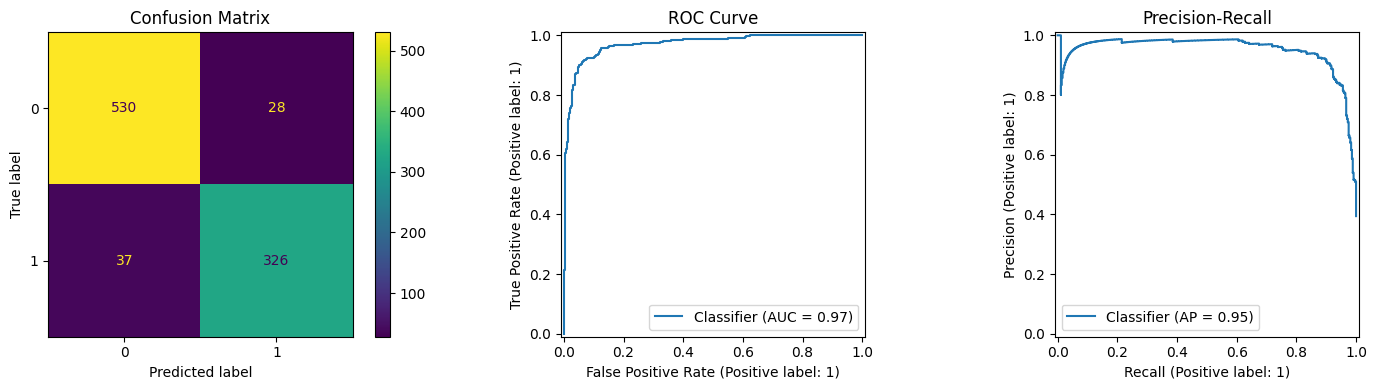

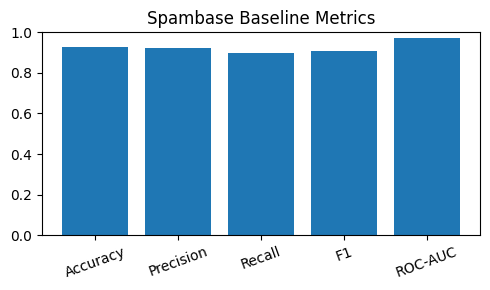

In [19]:
if cfg.RUN_SPAMBASE_BASELINE:
    X, y = load_spambase_hf()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=cfg.SEED, stratify=y
    )

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000)),
    ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, proba)

    print({"accuracy": acc, "precision": p, "recall": r, "f1": f1, "roc_auc": auc})

    # Plots
    try:
        import matplotlib.pyplot as plt
        from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=axes[0], values_format='d')
        axes[0].set_title("Confusion Matrix")

        RocCurveDisplay.from_predictions(y_test, proba, ax=axes[1])
        axes[1].set_title("ROC Curve")

        PrecisionRecallDisplay.from_predictions(y_test, proba, ax=axes[2])
        axes[2].set_title("Precision-Recall")

        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(figsize=(5, 3))
        ax.bar(["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"], [acc, p, r, f1, auc])
        ax.set_ylim(0, 1)
        ax.set_title("Spambase Baseline Metrics")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plotting failed. Install matplotlib to enable graphs.")
        print("Error:", e)
else:
    print("Spambase baseline skipped. Set cfg.RUN_SPAMBASE_BASELINE=True to run.")



## EML Parsing + Test
Parse a .eml file and run it through the trained model.


In [14]:
def predict_spam_from_eml(eml_path: str, threshold: float = 0.5) -> Dict:
    p = Path(eml_path)
    if not p.exists():
        raise FileNotFoundError(f"EML file not found: {p}")
    raw = p.read_bytes()
    text = parse_eml_bytes(raw)
    return predict_spam(text, threshold=threshold)


In [18]:
# Test with 4 samples in ./test
from pathlib import Path

tests = [
    ("spam_en.eml", "spam"),
    ("spam_he.eml", "spam"),
    ("ham_en.eml", "ham"),
    ("ham_he.eml", "ham"),
]

for name, expected in tests:
    p = Path("./test") / name
    if not p.exists():
        print(f"Missing test file: {p}")
        continue
    pred = predict_spam_from_eml(str(p))
    print(f"{name} (expected {expected}) -> {pred}")



spam_en.eml (expected spam) -> {'spam_probability': 0.999607264995575, 'prediction': 'SPAM'}
spam_he.eml (expected spam) -> {'spam_probability': 0.9950659275054932, 'prediction': 'SPAM'}
ham_en.eml (expected ham) -> {'spam_probability': 1.5029678252176382e-05, 'prediction': 'HAM'}
ham_he.eml (expected ham) -> {'spam_probability': 0.0018969200318679214, 'prediction': 'HAM'}
